# 

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from traffic.core import Traffic

#with open('', 'rb') as f:
df_original = Traffic.from_file('/mnt/data/synthair/synthair_diffusion/data/')
#with open('./ecmwf_2019_10_to_2019_10.pkl', "rb") as f:
 #   df_original = pickle.load(f)
#df_2 = Traffic.from_file('./other_features_200.pkl')
#df_original = df_original + df_2
import pandas as pd
import numpy as np
from geopy.distance import geodesic

FileNotFoundError: [Errno 2] No such file or directory: 'ecmwf_2019_10_to_2019_10.pkl'

In [2]:
df_original.loc['2019-10-02 09:00:00']

NameError: name 'df_original' is not defined

In [ ]:
import logging

# Enable logging
logging.basicConfig(level=logging.INFO)

In [2]:
import xarray
era5 = xarray.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2",
    chunks={'time': 48},
    consolidated=True,
)
era5

<xarray.Dataset> Size: 534TB
Dimensions:                                           (time: 552264,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 37)
Coordinates:
  * latitude                                          (latitude) float32 3kB ...
  * level                                             (level) int64 296B 1 .....
  * longitude                                         (longitude) float32 6kB ...
  * time                                              (time) datetime64[ns] 4MB ...
Data variables: (12/31)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 2TB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 2TB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 2TB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    geopotential                                      (time, level, latitude, longitude) float32 85TB dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>
    ...                                                ...
    total_precipitation                               (time, latitude, longitude) float32 2TB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    type_of_high_vegetation                           (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    type_of_low_vegetation                            (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    u_component_of_wind                               (time, level, latitude, longitude) float32 85TB dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>
    v_component_of_wind                               (time, level, latitude, longitude) float32 85TB dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>
    vertical_velocity                                 (time, level, latitude, longitude) float32 85TB dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>

In [45]:
import xarray as xr
import os
def preprocess2(ds):
    # Print the variables in the dataset
    #print("Variables in the dataset:", ds.data_vars)

    # Check if 'total_precipitation' is in the dataset
    if 'total_precipitation' in ds.data_vars:
        return ds
        total_precip = ds['total_precipitation']
        print("Found 'total_precipitation'. Checking for missing values...")

        # Check if there are missing values in 'total_precipitation' (NaNs)
        missing_vars = total_precip.isnull().sum(dim=['longitude', 'latitude', 'time'])
        
        # Print fields with missing values
        if missing_vars.any():
            print("Fields with missing values in 'total_precipitation':")
            print(missing_vars)
        else:
            print("'total_precipitation' has no missing values.")
    else:
        print("'total_precipitation' not found in the dataset.")
        print(ds.time)

    return ds['temperature'].sel(level=1000, latitude=60, longitude=18)
#f = traffic[0].data.loc[len(traffic[0])-1]
lon = 15
lat = 60
rounded_lon = lon
rounded_lat = lat
half_grid = 20 * 0.25
variables = ['total_cloud_cover', 'temperature','total_precipitation' ]
def preprocess(ds):
    # Check which variables have the 'level' dimension
    pressure_levels = np.array([ 850,  925, 1000])
    variables_with_level = [var for var in variables if 'level' in ds[var].dims]
    variables_without_level = [var for var in variables if 'level' not in ds[var].dims]
    print(variables_with_level)
    print(variables_without_level)
    # Select data for variables with 'level'
    ds_with_level = ds[variables_with_level].sel(
        level=pressure_levels, 
        longitude=slice(rounded_lon - half_grid, rounded_lon + half_grid), 
        latitude=slice(rounded_lat + half_grid, rounded_lat - half_grid),
    )

    # Select data for variables without 'level' and add a dummy 'level' dimension
    ds_without_level = ds[variables_without_level].sel(
        longitude=slice(rounded_lon - half_grid, rounded_lon + half_grid), 
        latitude=slice(rounded_lat + half_grid, rounded_lat - half_grid),
    )
    # Add a dummy 'level' dimension filled with zeros
            # Add a dummy 'level' dimension by copying data across all levels
    ds_without_level = ds_without_level.expand_dims(dim={'level': pressure_levels}).assign_coords(level=pressure_levels)
    ds_without_level = ds_without_level.map(lambda x: x.broadcast_like(ds_without_level))

    # Merge the two datasets
    return xr.merge([ds_with_level, ds_without_level])

def check_missing_total_precipitation(variables):
    # Open the dataset using the preprocess function
    save_path = "/mnt/data/synthair/synthair_diffusion/data/era5/"
    # List all .nc files in the directory
    nc_files = [save_path + f for f in os.listdir(save_path) if f.endswith('.nc') and "2020" in f]
    ds = xr.open_mfdataset(nc_files, combine='by_coords', preprocess=preprocess, chunks={'time': 100})
    return ds



ds = check_missing_total_precipitation(['temperature','total_cloud_cover', 'total_precipitation' ])

['temperature']
['total_cloud_cover', 'total_precipitation']
['temperature']
['total_cloud_cover', 'total_precipitation']
['temperature']
['total_cloud_cover', 'total_precipitation']
['temperature']
['total_cloud_cover', 'total_precipitation']
['temperature']
['total_cloud_cover', 'total_precipitation']
['temperature']
['total_cloud_cover', 'total_precipitation']
['temperature']
['total_cloud_cover', 'total_precipitation']
['temperature']
['total_cloud_cover', 'total_precipitation']
['temperature']
['total_cloud_cover', 'total_precipitation']
['temperature']
['total_cloud_cover', 'total_precipitation']
['temperature']
['total_cloud_cover', 'total_precipitation']
['temperature']
['total_cloud_cover', 'total_precipitation']


In [57]:
dssub = ds.sel(time='2020-01-03T13:00:00.000000000')
dssub

<xarray.Dataset> Size: 55kB
Dimensions:              (level: 3, latitude: 37, longitude: 41)
Coordinates:
  * latitude             (latitude) float32 148B 64.0 63.75 63.5 ... 55.25 55.0
  * level                (level) int64 24B 850 925 1000
  * longitude            (longitude) float32 164B 10.0 10.25 10.5 ... 19.75 20.0
    time                 datetime64[ns] 8B 2020-01-03T13:00:00
Data variables:
    temperature          (level, latitude, longitude) float32 18kB dask.array<chunksize=(3, 37, 41), meta=np.ndarray>
    total_cloud_cover    (level, latitude, longitude) float32 18kB dask.array<chunksize=(3, 37, 41), meta=np.ndarray>
    total_precipitation  (level, latitude, longitude) float32 18kB dask.array<chunksize=(3, 37, 41), meta=np.ndarray>

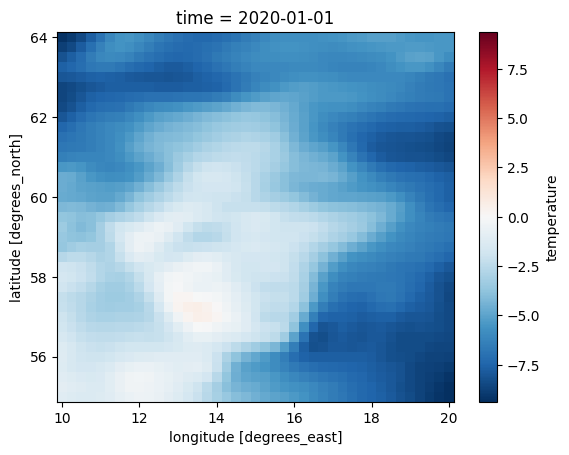

In [52]:
air2d = dssub.sel(level=850)['temperature'] - dssub.sel(level=1000)['temperature']

air2d.plot()

In [3]:
import numpy as np
subset = era5.sel(time=slice('2020-01-01 01:00:00', '2020-01-01 03:00:00'), latitude=slice(64.0, 38.0), 
                  longitude=slice(0.0, 20.0))
subset = subset[['10m_u_component_of_wind', '10m_v_component_of_wind', '2m_temperature','temperature',
                  'vertical_velocity', 'v_component_of_wind', 'u_component_of_wind'
                 #'geopotential', 
                 #'specific_humidity',  'total_cloud_cover', 'total_precipitation', 'total_column_water_vapour', 
                ]]
subset

<xarray.Dataset> Size: 15MB
Dimensions:                  (time: 3, latitude: 105, longitude: 81, level: 37)
Coordinates:
  * latitude                 (latitude) float32 420B 64.0 63.75 ... 38.25 38.0
  * level                    (level) int64 296B 1 2 3 5 7 ... 925 950 975 1000
  * longitude                (longitude) float32 324B 0.0 0.25 ... 19.75 20.0
  * time                     (time) datetime64[ns] 24B 2020-01-01T01:00:00 .....
Data variables:
    10m_u_component_of_wind  (time, latitude, longitude) float32 102kB dask.array<chunksize=(3, 105, 81), meta=np.ndarray>
    10m_v_component_of_wind  (time, latitude, longitude) float32 102kB dask.array<chunksize=(3, 105, 81), meta=np.ndarray>
    2m_temperature           (time, latitude, longitude) float32 102kB dask.array<chunksize=(3, 105, 81), meta=np.ndarray>
    temperature              (time, level, latitude, longitude) float32 4MB dask.array<chunksize=(3, 37, 105, 81), meta=np.ndarray>
    vertical_velocity        (time, level, latitude, longitude) float32 4MB dask.array<chunksize=(3, 37, 105, 81), meta=np.ndarray>
    v_component_of_wind      (time, level, latitude, longitude) float32 4MB dask.array<chunksize=(3, 37, 105, 81), meta=np.ndarray>
    u_component_of_wind      (time, level, latitude, longitude) float32 4MB dask.array<chunksize=(3, 37, 105, 81), meta=np.ndarray>

In [3]:
import xarray
save_path = "/mnt/data/synthair/synthair_diffusion/data/era5/"
#subset.to_netcdf(save_path + 'era5_subset_2020_test_4.nc')

In [8]:
ds = xarray.open_dataset(save_path + 'era5_subset_2020-04.nc')
ds = ds.sel(time='2020-04-01T00:00:00.000000000')


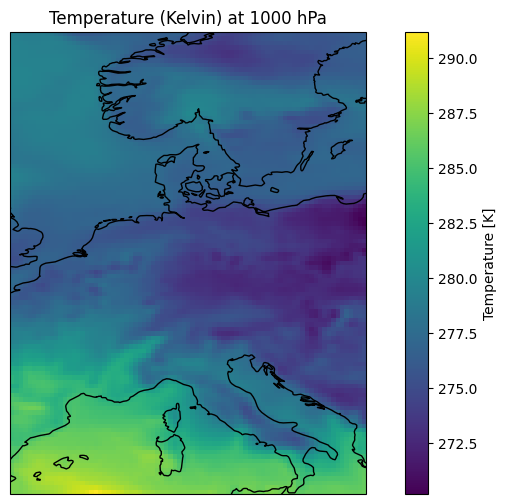

In [17]:
"""import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Assuming you already have the dataset loaded
# ds = xr.open_zarr(...)

# Select the temperature at a specific pressure level, e.g., level 500 hPa
temperature_level = dssub['total_precipitation']#.sel(level=1000)# + -273.15
#temperature_level = dssub['wind'].sel(level=1000)# + -273.15
# Plotting the data on a map
plt.figure(figsize=(10, 6))

# Create a Cartopy projection for plotting (PlateCarree is the most common)
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the temperature data
temperature_level.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', cbar_kwargs={'label': 'Total Precipitation'})
#ax.set_clim(-50,50)
# Add coastlines for context
ax.coastlines()

# Show the plot
plt.title('Total Precipitation')
plt.show()"""

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def plot_variable(ds, variable, level=None, cmap='coolwarm'):
    """
    Plots a specified variable from an xarray dataset with an optional level.
    
    Parameters:
    - ds: xarray.Dataset
        The dataset containing the variable to plot.
    - variable: str
        The variable name in the dataset to plot (e.g., 'total_precipitation', 'wind').
    - level: int, optional
        The pressure level to select (e.g., 500 for 500 hPa).
        If None, the level dimension will be ignored.
    - cmap: str, optional
        The colormap for the plot (default is 'coolwarm').
    """
    
    # Select the variable
    data = ds[variable]
    
    # If a level is provided and the dataset has a level dimension, select it
    if level is not None and 'level' in data.dims:
        data = data.sel(level=level)
    
    # Set labels based on variable type
    var_labels = {
        'total_precipitation': 'Total Precipitation (mm)',
        'wind': 'Wind (m/s)',
        'v_component_of_wind' : "V Component Wind (m/s)",
        'u_component_of_wind' : "U Component Wind (m/s)",
        "temperature" : "Temperature (Kelvin)",
        "total_cloud_cover" : "Total Cloud Coverage ([0-1])"
        # Add other variable names and labels as needed
    }
    label = var_labels.get(variable, variable)

    # Plotting
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    data.plot(ax=ax, transform=ccrs.PlateCarree())
    
    ax.coastlines()
    
    title = f"{label} {'at ' + str(level) + ' hPa' if level is not None else ''}"
    plt.title(title)
    plt.show()

#plot_variable(dssub, 'total_precipitation', level=1000)

# Without a specified level
plot_variable(ds, 'temperature', level=1000)

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from traffic.core import Traffic

#with open('', 'rb') as f:
df_original = Traffic.from_file('./resampled/combined_traffic_resampled_200.pkl')
#df_2 = Traffic.from_file('./OpenSky_EGLL_EHAM_trajectories.pkl')
#df_original = df_original + df_2
import pandas as pd
import numpy as np
from geopy.distance import geodesic
df_original

In [ ]:
a = df_original.between("2020-01-01", "2020-01-31")
ds = xarray.open_dataset(save_path + 'era5_subset_2020-01.nc')
import torch
variables = ['v_component_of_wind', 'u_component_of_wind', 'temperature', 'vertical_velocity']
for flight in a:
    t = flight.mean("timestamp").round('h')
    formatted_timestamp = t.strftime('%Y-%m-%d %H:00:00')
    sub = ds[variables].sel(time=formatted_timestamp)
    print(sub)
    print(torch.tensor(sub.to_array().values).shape)
    break



In [ ]:
a = df_original.between("2020-01-01", "2020-01-31")
save_path = "/mnt/data/synthair/synthair_diffusion/data/era5/"
ds = xarray.open_dataset(save_path + 'era5_subset_2020-01.nc')
variables = ['v_component_of_wind', 'u_component_of_wind', 'temperature', 'vertical_velocity']
timestamps = []
pressure_levels = np.array([ 100,  150,  200,  250,  300,  400,  500,  600,  700,  850,  925, 1000])

for flight in a:
    # Calculate the mean timestamp and round to the nearest hour
    t = flight.mean("timestamp").round('h')
    formatted_timestamp = t.strftime('%Y-%m-%d %H:00:00')
    
    # Add the rounded timestamp to the list
    timestamps.append(formatted_timestamp)

# Step 2: Convert timestamps to a format that can be used for selection (if needed)
# Remove duplicates to get unique timestamps
unique_timestamps = np.unique(timestamps)

# Step 3: Use these timestamps to subset the ERA5 dataset
# Subset the dataset with all timestamps that match
sub_ds = ds.sel(time=unique_timestamps).sel(level = pressure_levels)

# Now, 'sub_ds' is the subset containing only the data for the relevant flight timestamps
print(sub_ds)

# Optionally save the subset dataset for later use
sub_ds.to_netcdf(save_path + 'era5_2020-01_flight_filtered.nc')

In [ ]:
import xarray as xr
import numpy as np
import plotly.graph_objects as go

# Assuming you already have the dataset loaded
# ds = xr.open_zarr(...)

# Pressure levels array you provided
pressure_levels = np.array([1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000])
pressure_levels = np.array([ 100,  150,  200,  250,  300,  400,  500,  600,  700,  850,  925, 1000])

# Prepare a grid for the latitude, longitude, and pressure levels
lats = dssub['latitude'].values
lons = dssub['longitude'].values

# Create 2D grids for lat and lon
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Create a figure for the 3D plot
fig = go.Figure()

# Iterate over the pressure levels and plot each one with transparency
for pressure in pressure_levels:
    # Select the temperature at the current pressure level, converting from Kelvin to Celsius
    temperature_level = dssub['u_component_of_wind'].sel(level=pressure).values
    
    # Add a surface plot for each pressure level
    fig.add_trace(go.Surface(
        x=lon_grid,
        y=lat_grid,
        z=np.full_like(lon_grid, pressure),  # Pressure as the Z axis
        surfacecolor=temperature_level,  # Temperature mapped to color
        colorscale='RdBu',  # Use a suitable colormap (coolwarm is not directly available, so we use 'RdBu')
        opacity=0.6,  # Set the transparency
        colorbar=dict(title='10m_u_component_of_wind (°C)'),
        showscale=False  # Disable individual colorbars for each surface
    ))

# Set labels and titles
fig.update_layout(
    scene=dict(
        xaxis_title='Longitude',
        yaxis_title='Latitude',
        zaxis_title='Pressure Level (hPa)',
        zaxis=dict(autorange='reversed')  # Reverse the Z axis for pressure
    ),
    title='Temperature across Pressure Levels (with Transparency)',
    coloraxis_colorbar=dict(title='10m_u_component_of_wind (°C)')
)

# Add a single colorbar for the whole plot
fig.update_layout(coloraxis_colorbar=dict(title="10m_u_component_of_wind (°C)"))

# Show the interactive plot
fig.show()


In [133]:
df_2 = Traffic.from_file('./resampled/combined_traffic_resampled_200.pkl')
df_2

,count
flight_id,
300064_AZA107_20180529_102200,200
484b92_KLM81K_20210825_081600,200
484c59_KLM41L_20181223_180619,200
484c59_KLM41L_20181112_162318,200
484c59_KLM41L_20181111_161923,200
484c59_KLM41L_20181109_162100,200
484c59_KLM41L_20181108_160756,200
484c59_KLM41L_20181106_160931,200
484c59_KLM41L_20181105_161034,200


In [31]:
import os
import xarray as xr
variables = ['v_component_of_wind', 'u_component_of_wind', 'temperature', 'vertical_velocity']
pressure_levels = np.array([ 100,  150,  200,  250,  300,  400,  500,  600,  700,  850,  925, 1000])
pressure_levels = np.array([   1,    2,    3,    5,    7,   10,   20,   30,   50,   70,  100,  125,
        150,  175,  200,  225,  250,  300,  350,  400,  450,  500,  550,  600,
        650,  700,  750,  775,  800,  825,  850,  875,  900,  925,  950,  975,
       1000])
def preprocess(ds):
    return ds[variables].sel(level=pressure_levels)

save_path = "/mnt/data/synthair/synthair_diffusion/data/era5/"
# List all .nc files in the directory
nc_files = [save_path + f for f in os.listdir(save_path) if f.endswith('.nc') and not "2021" in f]
print(nc_files)
# Open all the .nc files in the directory as a single dataset
ds = xr.open_mfdataset(nc_files, combine='by_coords', preprocess=preprocess, decode_cf=True)
print("loaded_data")
ds

['/mnt/data/synthair/synthair_diffusion/data/era5/era5_subset_2020-12.nc', '/mnt/data/synthair/synthair_diffusion/data/era5/era5_subset_2020-06.nc', '/mnt/data/synthair/synthair_diffusion/data/era5/era5_subset_2020-07.nc', '/mnt/data/synthair/synthair_diffusion/data/era5/era5_subset_2019-11.nc', '/mnt/data/synthair/synthair_diffusion/data/era5/era5_subset_2020-04.nc', '/mnt/data/synthair/synthair_diffusion/data/era5/era5_subset_2020-03.nc', '/mnt/data/synthair/synthair_diffusion/data/era5/era5_subset_2019-02.nc', '/mnt/data/synthair/synthair_diffusion/data/era5/era5_subset_2018-03.nc', '/mnt/data/synthair/synthair_diffusion/data/era5/era5_subset_2018-06.nc', '/mnt/data/synthair/synthair_diffusion/data/era5/era5_subset_2019-01.nc', '/mnt/data/synthair/synthair_diffusion/data/era5/era5_subset_2018-02.nc', '/mnt/data/synthair/synthair_diffusion/data/era5/era5_subset_2019-07.nc', '/mnt/data/synthair/synthair_diffusion/data/era5/era5_subset_2018-11.nc', '/mnt/data/synthair/synthair_diffusio

/home/olavfpl/SynTraj/syntraj/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.Dataset> Size: 132GB
Dimensions:              (time: 26304, level: 37, latitude: 105, longitude: 81)
Coordinates:
  * latitude             (latitude) float32 420B 64.0 63.75 63.5 ... 38.25 38.0
  * level                (level) int64 296B 1 2 3 5 7 ... 900 925 950 975 1000
  * longitude            (longitude) float32 324B 0.0 0.25 0.5 ... 19.75 20.0
  * time                 (time) datetime64[ns] 210kB 2018-01-01 ... 2020-12-3...
Data variables:
    v_component_of_wind  (time, level, latitude, longitude) float32 33GB dask.array<chunksize=(744, 37, 105, 81), meta=np.ndarray>
    u_component_of_wind  (time, level, latitude, longitude) float32 33GB dask.array<chunksize=(744, 37, 105, 81), meta=np.ndarray>
    temperature          (time, level, latitude, longitude) float32 33GB dask.array<chunksize=(744, 37, 105, 81), meta=np.ndarray>
    vertical_velocity    (time, level, latitude, longitude) float32 33GB dask.array<chunksize=(744, 37, 105, 81), meta=np.ndarray>

In [71]:
import torch
from tqdm import tqdm
from utils.weather_utils import load_weather_arrival_airport
def pad_or_crop_grid(grid, target_shape):
    """
    Pads or crops the grid to match the target shape (variables, levels, grid_size, grid_size).
    
    Args:
        grid (numpy.ndarray): Input array of shape (variables, levels, grid_size, grid_size).
        target_shape (tuple): Target shape (target_vars, target_levels, target_grid_size, target_grid_size).
        
    Returns:
        numpy.ndarray: The padded or cropped grid.
    """
    target_vars, target_levels, target_rows, target_cols = target_shape
    current_vars, current_levels, current_rows, current_cols = grid.shape

    # Pad or crop variables
    if current_vars < target_vars:
        pad_vars = target_vars - current_vars
        grid = np.pad(grid, ((0, pad_vars), (0, 0), (0, 0), (0, 0)), mode='constant')
    elif current_vars > target_vars:
        grid = grid[:target_vars, :, :, :]

    # Pad or crop levels
    if current_levels < target_levels:
        pad_levels = target_levels - current_levels
        grid = np.pad(grid, ((0, 0), (0, pad_levels), (0, 0), (0, 0)), mode='constant')
    elif current_levels > target_levels:
        grid = grid[:, :target_levels, :, :]

    # Pad or crop rows
    if current_rows < target_rows:
        pad_rows = target_rows - current_rows
        grid = np.pad(grid, ((0, 0), (0, 0), (0, pad_rows), (0, 0)), mode='constant')
    elif current_rows > target_rows:
        grid = grid[:, :, :target_rows, :]

    # Pad or crop columns
    if current_cols < target_cols:
        pad_cols = target_cols - current_cols
        grid = np.pad(grid, ((0, 0), (0, 0), (0, 0), (0, pad_cols)), mode='constant')
    elif current_cols > target_cols:
        grid = grid[:, :, :, :target_cols]

    return grid

def retrieve_closest_pressure(pressure_hPa, pressure_levels = np.array([   1,    2,    3,    5,    7,   10,   20,   30,   50,   70,  100,  125,
        150,  175,  200,  225,  250,  300,  350,  400,  450,  500,  550,  600,
        650,  700,  750,  775,  800,  825,  850,  875,  900,  925,  950,  975,
       1000])):
    """ Retrieve the closest pressure level in the ERA5 dataset to the given pressure
    Args:
        pressure_hPa: float
    """
    return min(pressure_levels, key=lambda x:abs(x-pressure_hPa))

def hPa_to_m(pressure_hPa):
    """ Convert pressure in hPa to meters
    Args:
        pressure_hPa: float
    """
    return 145366.45 * (1 - (pressure_hPa / 1013.25)**0.190284)

def m_to_hPa(altitude_m):
    """ Convert altitude in meters to hPa
    Args:
        altitude_m: float
    """
    return 1013.25 * (1 - 2.2577e-5 * altitude_m )**5.25588

def find_nearest_pressure_levels(altitude, num_levels, pressure_levels = np.array([   1,    2,    3,    5,    7,   10,   20,   30,   50,   70,  100,  125,
        150,  175,  200,  225,  250,  300,  350,  400,  450,  500,  550,  600,
        650,  700,  750,  775,  800,  825,  850,  875,  900,  925,  950,  975,
       1000])):
    """ 
    Map an altitude to the nearest available pressure level and return surrounding levels.
    
    Args:
        altitude: float, altitude in meters
        num_levels: int, number of levels to retrieve (total number, so num_levels // 2 above and below)
        pressure_levels: numpy array of available pressure levels in hPa
    
    Returns:
        list: Sorted list of pressure levels including the nearest and surrounding levels.
    """
    # Convert altitude to pressure (if needed), here using a placeholder conversion for example
    pressure_hPa = m_to_hPa(altitude)  # Convert altitude (meters) to pressure in hPa
    
    # Find the index of the nearest pressure level
    closest_index = np.abs(pressure_levels - pressure_hPa).argmin()
    
    # Calculate the range of indices to select surrounding levels
    half_num_levels = num_levels // 2
    start_index = max(0, closest_index - half_num_levels)
    end_index = min(len(pressure_levels), closest_index + half_num_levels + 1)  # +1 to include the end index
    
    # Select surrounding pressure levels
    selected_levels = pressure_levels[start_index:end_index]
    
    return selected_levels

def round_to_nearest_0_25(value):
    """Round the input value to the nearest 0.25."""
    return round(value * 4) / 4

for flight in df_2:
    # Extracting the average time for the flight and rounding it to the nearest hour
    t = flight.mean("timestamp").round('h')
    formatted_timestamp = t.strftime('%Y-%m-%d %H:00:00')
    
    # Select sub-dataset for the timestamp
    sub = ds.sel(time=formatted_timestamp)
    
    flight_grids = []
    num_levels = 3
    grid_size = 3

    for i in tqdm(range(len(flight))):
        point = flight.data.loc[i]
        lon, lat, alt = point['longitude'], point['latitude'], point['altitude']
        alt = alt * 0.3048
        
        nearest_levels = find_nearest_pressure_levels(alt, num_levels)
        rounded_lon = round_to_nearest_0_25(lon)
        rounded_lat = round_to_nearest_0_25(lat)

        half_grid = grid_size // 2 * 0.25
        #print(slice(rounded_lon - half_grid, rounded_lon + half_grid, 0.25))
        #print(slice(rounded_lat - half_grid, rounded_lat + half_grid, 0.25))
        #print(sub)
        grid = sub.sel(
            longitude=slice(rounded_lon - half_grid, rounded_lon + half_grid), 
            latitude=slice(rounded_lat + half_grid, rounded_lat - half_grid), 
            level=nearest_levels  # Use the pressure levels obtained from the previous step
        ).to_array().fillna(0).values  # Filling NaNs with 0

        #print("GRID SHAPE:", grid.shape)
        # Ensure the grid shape is (num_levels, grid_size, grid_size)
        if grid.shape[2:4] != (grid_size, grid_size) or grid.shape[1] != num_levels:
            # Handle cases where grid extraction may be smaller due to boundaries
            grid = pad_or_crop_grid(grid, target_shape=(4, num_levels, grid_size, grid_size))
        flight_grids.append((torch.FloatTensor(grid), (lon, lat, alt)))
    break

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [06:28<00:00,  1.94s/it]


In [279]:
def load_weather_data_arrival_airport(traffic, variables, grid_size=5, num_levels=3,
        pressure_levels = np.array([ 850,  925, 1000])):

    f = traffic[0].data.loc[len(traffic[0])-1]
    lon = f['longitude']
    lat = f['latitude']
    rounded_lon = round_to_nearest_0_25(lon)
    rounded_lat = round_to_nearest_0_25(lat)
    half_grid = grid_size // 2 * 0.25
    
    def preprocess(ds):
        return ds[variables].sel(
            level=pressure_levels, 
            longitude=slice(rounded_lon - half_grid, rounded_lon + half_grid), 
            latitude=slice(rounded_lat + half_grid, rounded_lat - half_grid), 
            )

    #ds = xr.open_mfdataset(file_paths, combine='by_coords', preprocess=preprocess, chunks={'time': 100})
    print("Data loaded")

    grid_conditions = []
    for flight in tqdm(df_2):
        # Extracting the average time for the flight and rounding it to the nearest hour
        t = flight.mean("timestamp").round('h')
        formatted_timestamp = t.strftime('%Y-%m-%d %H:00:00')
        
        
        # Select sub-dataset for the timestamp
        sub = ds.sel(time=formatted_timestamp)
        
        # Convert the selected subset to a PyTorch FloatTensor, filling NaN values if necessary
        #data_array = sub.to_array().fillna(0).values  # Filling NaNs with 0 or another appropriate value
        data_array = sub.to_array().values
        grid_conditions.append(torch.FloatTensor(data_array))
        break
    return grid_conditions, rounded_lon, rounded_lat

grid_list, lon, lat = load_weather_data_arrival_airport(df_2, variables, 5, 3)


Data loaded


  0%|                                                                                                                                                                                                                                                          | 0/7630 [00:02<?, ?it/s]


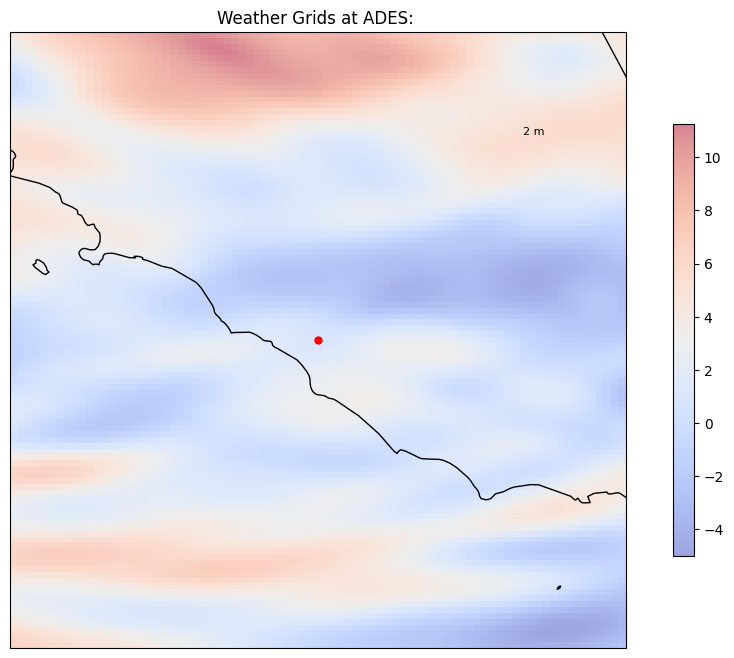

In [297]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Set up a color map
cmap = "coolwarm"

# Initialize variables to track the min and max values for the colorbar
all_data = []

# Now loop through the flight grids and plot each one
for grid in grid_list:
    #print(grid)
    # Select the weather grid at the specified altitude (level)
    data = grid[0][0]  # Assuming that grid has the shape (level, lon, lat), and we take the first level
    lon = lon
    lat = lat
    # Calculate the extent for the grid to be placed at the correct (lon, lat) location
    half_grid = grid_size / 2.0
    
    extent = [lon - half_grid, lon + half_grid, lat - half_grid, lat + half_grid]

    # Plotting the grid
    im = ax.imshow(data, transform=ccrs.PlateCarree(), cmap=cmap, 
                   alpha=0.5, extent=extent, origin='lower')

    # Mark the position on the flight trajectory with a red dot
    ax.plot(lon, lat, 'ro', markersize=5, transform=ccrs.PlateCarree())

    # Optionally annotate the altitude
    ax.text(lon + 1, lat + 1, f"2 m", fontsize=8, color="black", transform=ccrs.PlateCarree())

# Set the title of the plot
title = "welp"
plt.title(f"Weather Grids at ADES: ")

# Add a colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.7, pad=0.05)
#cbar.set_label(label)

plt.show()

In [ ]:
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()

    # Set up a color map
    cmap = "coolwarm"
    
    # Initialize variables to track the min and max values for the colorbar
    all_data = []

    # Loop through all flight grids and collect data to determine the global min/max
    for grid, (lon, lat, alt) in flight_grids:
        # Select the weather grid at the specified altitude (level)
        data = grid[2][0]  # Assuming that grid has the shape (level, lon, lat), and we take the first level
        all_data.append(data)

    # Flatten all the data and calculate the global min/max for color scaling
    all_data = torch.cat(all_data, dim=-1).flatten()
    vmin = all_data.min().item()
    vmax = all_data.max().item()

    # Now loop through the flight grids and plot each one
    for grid, (lon, lat, alt) in flight_grids:
        # Select the weather grid at the specified altitude (level)
        data = grid[2][0]  # Assuming that grid has the shape (level, lon, lat), and we take the first level
        
        # Calculate the extent for the grid to be placed at the correct (lon, lat) location
        half_grid = grid_size / 2.0
        extent = [lon - half_grid, lon + half_grid, lat - half_grid, lat + half_grid]

        # Plotting the grid
        im = ax.imshow(data, transform=ccrs.PlateCarree(), cmap=cmap, 
                       alpha=alpha, extent=extent, origin='lower', vmin=vmin, vmax=vmax)

        # Mark the position on the flight trajectory with a red dot
        ax.plot(lon, lat, 'ro', markersize=5, transform=ccrs.PlateCarree())

        # Optionally annotate the altitude
        ax.text(lon + 1, lat + 1, f"{int(alt)} m", fontsize=8, color="black", transform=ccrs.PlateCarree())

    # Set the title of the plot
    title = f"{label} {'at ' + str(level) + ' hPa' if level is not None else ''}"
    plt.title(f"Weather Grids Along Flight Trajectory: {title}")

    # Add a colorbar
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.7, pad=0.05)
    cbar.set_label(label)
    
    plt.show()

In [65]:
t_fg = torch.stack(flight_grids, dim=0)
t_fg.shape

TypeError: expected Tensor as element 0 in argument 0, but got tuple

In [72]:
for d, t in flight_grids:
    print(d[2][0], t[2], m_to_hPa(t[2]))

tensor([[293.9102, 293.9357, 293.7377],
        [293.7671, 293.6548, 293.2869],
        [293.4354, 293.2428, 292.9244]]) 601.98 942.9339671162129
tensor([[289.6645, 289.6671, 289.6856],
        [289.8043, 289.7502, 289.6698],
        [289.6830, 289.5919, 289.4192]]) 891.5400000000001 910.548469342017
tensor([[287.5318, 287.4808, 287.4324],
        [287.4612, 287.3774, 287.3264],
        [287.3866, 287.3068, 287.2820]]) 1120.14 885.6223481402244
tensor([[287.5318, 287.4808, 287.4324],
        [287.4612, 287.3774, 287.3264],
        [287.3866, 287.3068, 287.2820]]) 1272.54 869.3140925996343
tensor([[283.4731, 283.5572, 283.6451],
        [283.5171, 283.5818, 283.6413],
        [283.5339, 283.5688, 283.6231]]) 1638.3000000000002 831.1645751265216
tensor([[279.7366, 279.8054, 279.8692],
        [279.9805, 279.9968, 280.0180],
        [280.1231, 280.0993, 280.0843]]) 2148.84 780.1917732841252
tensor([[275.8389, 275.8546, 275.8739],
        [275.9246, 275.9173, 275.8992],
        [275.9511, 

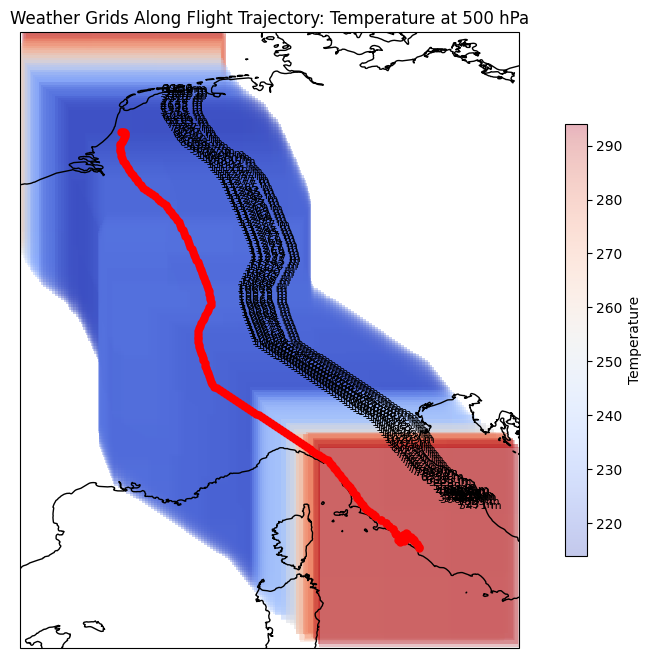

In [73]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def plot_weather_grids_on_trajectory(flight_grids, label="Weather Variable", alpha=0.3, level=None, grid_size=5):
    """
    Plots the weather grids overlaid on a map based on the flight trajectory.
    
    Args:
        flight_grids (list): List of tuples where each tuple contains:
                              - a tensor of shape (level, lon, lat) representing the weather grid.
                              - a tuple (lon, lat, alt) for the flight's location.
        label (str): Label for the weather variable (for the colorbar).
        alpha (float): Transparency level for plotting the grids.
        level (int, optional): The pressure level to display (if provided).
        grid_size (int): Size of the grid (e.g., 5x5).
    """
    # Create a figure with Cartopy projection
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()

    # Set up a color map
    cmap = "coolwarm"
    
    # Initialize variables to track the min and max values for the colorbar
    all_data = []

    # Loop through all flight grids and collect data to determine the global min/max
    for grid, (lon, lat, alt) in flight_grids:
        # Select the weather grid at the specified altitude (level)
        data = grid[2][0]  # Assuming that grid has the shape (level, lon, lat), and we take the first level
        all_data.append(data)

    # Flatten all the data and calculate the global min/max for color scaling
    all_data = torch.cat(all_data, dim=-1).flatten()
    vmin = all_data.min().item()
    vmax = all_data.max().item()

    # Now loop through the flight grids and plot each one
    for grid, (lon, lat, alt) in flight_grids:
        # Select the weather grid at the specified altitude (level)
        data = grid[2][0]  # Assuming that grid has the shape (level, lon, lat), and we take the first level
        
        # Calculate the extent for the grid to be placed at the correct (lon, lat) location
        half_grid = grid_size / 2.0
        extent = [lon - half_grid, lon + half_grid, lat - half_grid, lat + half_grid]

        # Plotting the grid
        im = ax.imshow(data, transform=ccrs.PlateCarree(), cmap=cmap, 
                       alpha=alpha, extent=extent, origin='lower', vmin=vmin, vmax=vmax)

        # Mark the position on the flight trajectory with a red dot
        ax.plot(lon, lat, 'ro', markersize=5, transform=ccrs.PlateCarree())

        # Optionally annotate the altitude
        ax.text(lon + 1, lat + 1, f"{int(alt)} m", fontsize=8, color="black", transform=ccrs.PlateCarree())

    # Set the title of the plot
    title = f"{label} {'at ' + str(level) + ' hPa' if level is not None else ''}"
    plt.title(f"Weather Grids Along Flight Trajectory: {title}")

    # Add a colorbar
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.7, pad=0.05)
    cbar.set_label(label)
    
    plt.show()

# Example usage
# Assuming `t_fg` is a list-like object containing data with shape (level, longitude, latitude)
plot_weather_grids_on_trajectory(flight_grids, label="Temperature", level=500)

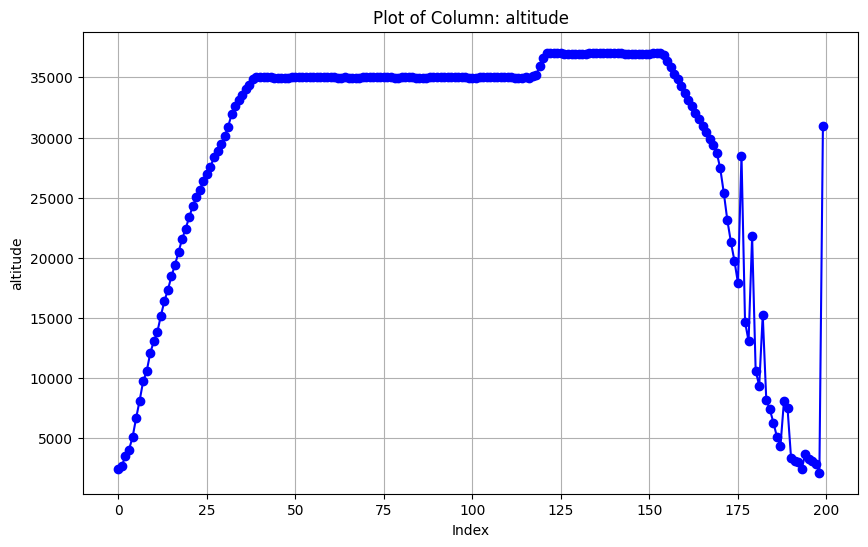

In [223]:
# Plotting function
def plot_column(df, column_name):
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in DataFrame.")
        return
    
    plt.figure(figsize=(10, 6))
    plt.plot(df[column_name], marker='o', linestyle='-', color='b')
    plt.title(f'Plot of Column: {column_name}')
    plt.xlabel('Index')
    plt.ylabel(column_name)
    plt.grid(True)
    plt.show()

# Specify the column to plot
column_to_plot = 'Sample Column'
plot_column(df_2[2].data, "altitude")

In [87]:
df_2 = df_2.clean_invalid(1)
df_2

,count
flight_id,
300064_AZA107_20180529_102200,200
484b92_KLM81K_20210825_081600,200
484c59_KLM41L_20181223_180619,200
484c59_KLM41L_20181112_162318,200
484c59_KLM41L_20181111_161923,200
484c59_KLM41L_20181109_162100,200
484c59_KLM41L_20181108_160756,200
484c59_KLM41L_20181106_160931,200
484c59_KLM41L_20181105_161034,200


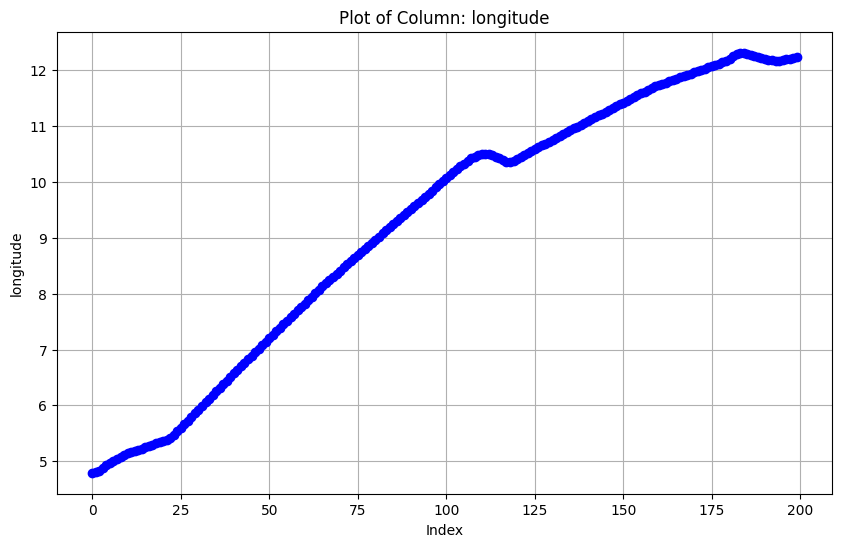

In [94]:
plot_column(df_2[1].data, "longitude")

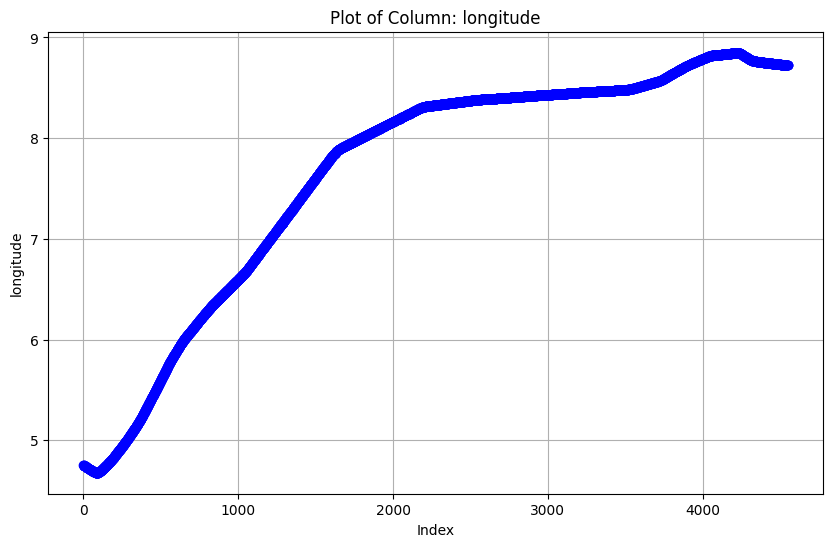

In [95]:
df_original = Traffic.from_file('/mnt/data/synthair/synthair_diffusion/data/opensky/OpenSky_EHAM_LIMC_trajectories.pkl')


In [ ]:
plot_column(df_original[1].data, "longitude")

                        flight_id  count
0  06a1e7_QTR8202_20180423_154221   4552
1  06a1eb_QTR8202_20200316_164155   4552


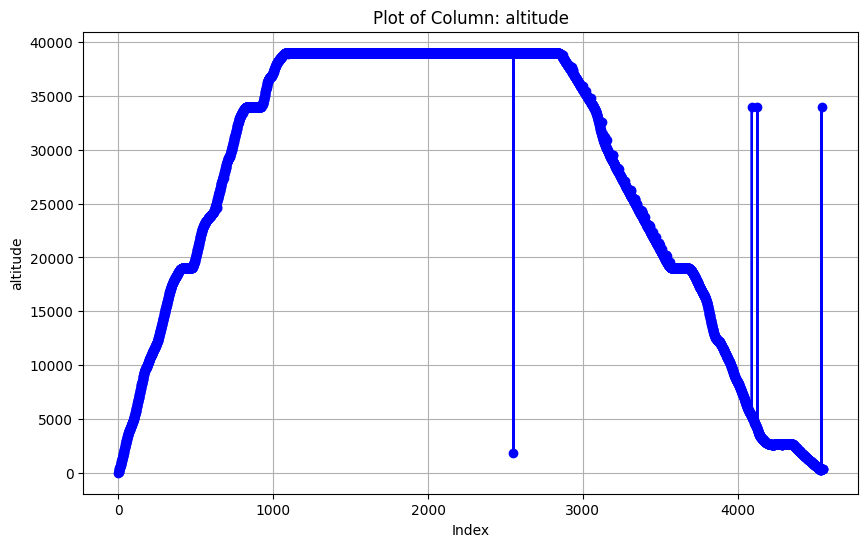

In [93]:
def remove_and_interpolate_altitude_outliers(traffic: Traffic, threshold: float = 3.0):
    """
    Removes altitude outliers from each flight in a Traffic object and interpolates missing values.
    
    Parameters:
    - traffic: The Traffic object containing flights.
    - threshold: The number of standard deviations used for outlier detection (default is 3).
    
    Returns:
    - traffic_cleaned: A new Traffic object with altitude outliers removed and interpolated.
    """
    def process_flight(flight):
        # Copy the DataFrame to avoid modifying the original one
        df = flight.data.copy()
        
        # Check if 'altitude' column exists
        if 'altitude' not in df.columns:
            print(f"Flight {flight.callsign} has no 'altitude' data.")
            return None

        # Calculate mean and standard deviation of the altitude
        mean_altitude = df['altitude'].mean()
        std_altitude = df['altitude'].std()

        # Identify outliers (values beyond the specified number of standard deviations)
        is_outlier = np.abs(df['altitude'] - mean_altitude) > threshold * std_altitude

        # Remove outliers by setting them to NaN
        df.loc[is_outlier, 'altitude'] = np.nan

        # Interpolate missing values (linear interpolation)
        df['altitude'] = df['altitude'].interpolate()

        # Return a new flight with the processed data
        flight.data = df
        return flight

    # Apply processing to all flights and create a new Traffic object
    for f in traffic:
        f = process_flight(f)
    #traffic_cleaned = traffic.map(process_flight, progressbar=True).filter(lambda f: f is not None)

    return traffic

cleaned = remove_and_interpolate_altitude_outliers(df_original[:2])
print(cleaned)
plot_column(cleaned[1].data, "altitude")

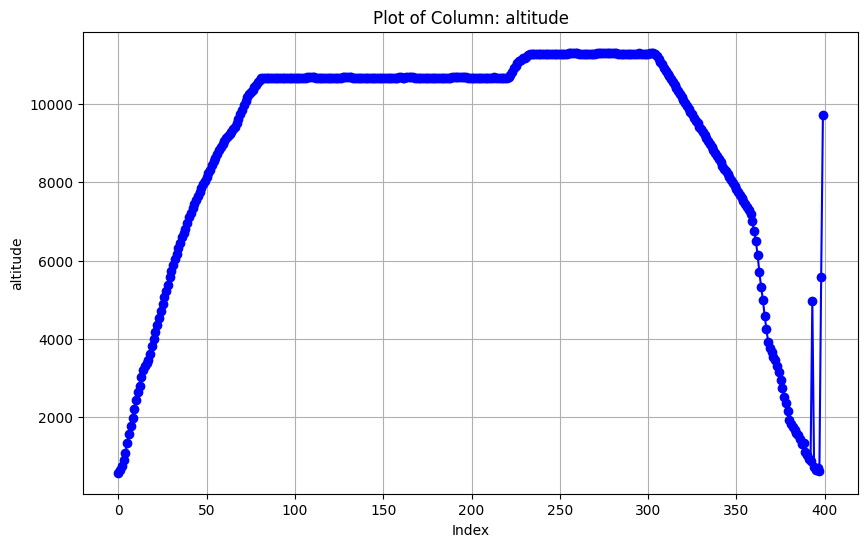

array([  586.74,   662.94,   769.62,   914.4 ,  1089.66,  1356.36,
        1577.34,  1783.08,  1973.58,  2209.8 ,  2446.02,  2644.14,
        2804.16,  3032.76,  3200.4 ,  3299.46,  3375.66,  3467.1 ,
        3627.12,  3817.62,  3992.88,  4175.76,  4351.02,  4541.52,
        4709.16,  4884.42,  5059.68,  5212.08,  5372.1 ,  5570.22,
        5722.62,  5890.26,  6035.04,  6172.2 ,  6316.98,  6454.14,
        6591.3 ,  6697.98,  6804.66,  6949.44,  7101.84,  7216.14,
        7338.06,  7452.36,  7551.42,  7635.24,  7741.92,  7840.98,
        7940.04,  8023.86,  8130.54,  8221.98,  8321.04,  8427.72,
        8526.78,  8618.22,  8724.9 ,  8816.34,  8892.54,  8961.12,
        9037.32,  9128.76,  9182.1 ,  9235.44,  9288.78,  9342.12,
        9418.32,  9509.76,  9608.82,  9738.36,  9837.42,  9959.34,
       10066.02, 10172.7 , 10241.28, 10287.  , 10355.58, 10416.54,
       10469.88, 10553.7 , 10614.66, 10652.76, 10668.  , 10668.  ,
       10668.  , 10668.  , 10668.  , 10668.  , 10668.  , 10668

In [224]:
df_4 = Traffic.from_file('./resampled/combined_traffic_resampled_400.pkl')
plot_column(df_4[1].data, "altitude")
df_4[1].data['altitude'].to_numpy()

In [256]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline

def estimate_trajectory_dynamics(trajectory_df):
    """
    Estimate trajectory dynamics with velocity and acceleration
    
    Parameters:
    - trajectory_df: DataFrame with time, latitude, longitude, altitude
    
    Returns:
    - DataFrame with additional columns for velocity, acceleration, predicted altitude
    """
    # Ensure sorted by timestamp
    trajectory_df = trajectory_df.sort_values('timestamp')
    
    # Calculate time deltas
    #trajectory_df['time_delta'] = trajectory_df['timestamp'].diff()
    
    # Compute velocity vectors
    trajectory_df['velocity_lat'] = np.gradient(trajectory_df['latitude'], trajectory_df['timedelta'])
    trajectory_df['velocity_lon'] = np.gradient(trajectory_df['longitude'], trajectory_df['timedelta'])
    trajectory_df['velocity_alt'] = np.gradient(trajectory_df['altitude'], trajectory_df['timedelta'])
    
    # Compute acceleration vectors
    trajectory_df['accel_lat'] = np.gradient(trajectory_df['velocity_lat'], trajectory_df['timedelta'])
    trajectory_df['accel_lon'] = np.gradient(trajectory_df['velocity_lon'], trajectory_df['timedelta'])
    trajectory_df['accel_alt'] = np.gradient(trajectory_df['velocity_alt'], trajectory_df['timedelta'])
    
    # Predict altitude using polynomial interpolation
    altitude_spline = InterpolatedUnivariateSpline(
        trajectory_df['timedelta'], 
        trajectory_df['altitude'], 
        k=3  # cubic spline
    )
    trajectory_df['predicted_altitude'] = altitude_spline(trajectory_df['timedelta'])
    
    # Identify anomalous points
    alt_residuals = np.abs(trajectory_df['altitude'] - trajectory_df['predicted_altitude'])
    threshold = alt_residuals.median() + 2 * alt_residuals.std()
    trajectory_df['is_anomaly'] = alt_residuals > threshold
    
    return trajectory_df


    
def remove_local_outliers(df, window_size=10, iqr_multiplier=3):
    """
    Identify and replace local outliers in altitude data.
    
    Parameters:
    - df (pandas.DataFrame): DataFrame with 'altitude' column
    - window_size (int): Size of rolling window for outlier detection
    - iqr_multiplier (float): Multiplier for IQR threshold
    
    Returns:
    - pandas.DataFrame: Original DataFrame with outliers replaced
    """
    df = df.copy()
    
    # Calculate rolling upper/lower bounds and IQR
    df['upper'] = df['altitude'].rolling(window_size).quantile(0.75)
    df['lower'] = df['altitude'].rolling(window_size).quantile(0.25)
    df['iqr'] = df['altitude'].rolling(window_size).apply(lambda x: np.subtract(*np.percentile(x, [75, 25])))
    
    # Identify outliers
    df['is_outlier'] = (df['altitude'] < df['lower'] - df['iqr'] * iqr_multiplier) | (df['altitude'] > df['upper'] + df['iqr'] * iqr_multiplier)
    
    # Replace outliers with rolling mean
    df.loc[df['is_outlier'], 'altitude'] = df['altitude'].rolling(window_size).mean()
    
    return df

def correct_landing_altitude(df, landing_threshold=50):
    """
    Correct altitude near landing by identifying landing phase.
    
    Parameters:
    - df (pandas.DataFrame): DataFrame with 'timestamp' and 'altitude' columns
    - landing_threshold (float): Altitude threshold for detecting landing (meters)
    
    Returns:
    - pandas.DataFrame: Original DataFrame with corrected landing altitude
    """
    # Sort the DataFrame by timestamp
    df = df.sort_values('timestamp')
    
    # Detect landing phase
    landing_mask = df['altitude'] < landing_threshold
    
    # Get the median altitude during the landing phase
    landing_altitude = df.loc[landing_mask, 'altitude'].median()
    
    # Correct the altitude during landing phase
    df.loc[landing_mask, 'altitude'] = landing_altitude
    
    return df
    
from scipy.signal import butter, filtfilt

def apply_butterworth_filter(df, cutoff_frequency=0.1, order=4):
    """
    Apply a Butterworth low-pass filter to the altitude data.
    
    Parameters:
    - df (pandas.DataFrame): DataFrame with 'timestamp' and 'altitude' columns
    - cutoff_frequency (float): Cutoff frequency for the low-pass filter (Hz)
    - order (int): Order of the Butterworth filter
    
    Returns:
    - pandas.DataFrame: Original DataFrame with 'smoothed_altitude' column
    """
    nyquist_frequency = 1 / (2 * df['timestamp'].diff().median())
    normalized_cutoff = cutoff_frequency / nyquist_frequency

    b, a = butter(order, normalized_cutoff, btype='low', analog=False)
    df['smoothed_altitude'] = filtfilt(b, a, df['altitude'])

    return df

from scipy.signal import butter, filtfilt, savgol_filter

def smooth_altitude(altitude, fs=1, cutoff=0.1, order=4, window_size=15, poly_order=3, landing_threshold=1000):
    """
    Apply two-stage smoothing to the altitude data.
    
    Parameters:
    - altitude (np.ndarray): Array of altitude values
    - fs (float): Sampling frequency (samples per second)
    - cutoff (float): Cutoff frequency for Butterworth filter (Hz)
    - order (int): Order of the Butterworth filter
    - window_size (int): Window size for Savitzky-Golay filter
    - poly_order (int): Polynomial order for Savitzky-Golay filter
    - landing_threshold (float): Altitude threshold for detecting landing phase (meters)
    
    Returns:
    - np.ndarray: Smoothed altitude values
    """
    # Step 1: Apply Butterworth low-pass filter to entire altitude profile
    nyquist = fs / 2
    normalized_cutoff = cutoff / nyquist
    b, a = butter(order, normalized_cutoff, btype='low', analog=False)
    smoothed_altitude = filtfilt(b, a, altitude)
    
    # Step 2: Apply Savitzky-Golay filter to landing phase
    landing_mask = altitude < landing_threshold
    smoothed_altitude[landing_mask] = savgol_filter(
        smoothed_altitude[landing_mask],
        window_length=window_size,
        polyorder=poly_order
    )
    
    # Step 3: Handle erratic last 20 data points
    if altitude.size >= 10 and np.max(altitude[-10:]) > 2 * np.median(altitude[-10:]):
        smoothed_altitude[-10:] = np.median(altitude[-10:])
    
    return smoothed_altitude
# Example usage
#altitude = np.array([...]) # your altitude data
smoothed_altitude = df_4[2].data
smoothed_altitude['altitude'] = smooth_altitude(df_4[2].data['altitude'], fs=1, cutoff=0.1, order=4, window_size=10, poly_order=3)

smoothed_df = remove_local_outliers(df_4[2].data, 50, 2)
dynamics_df = estimate_trajectory_dynamics(smoothed_df)
corrected_df = correct_landing_altitude(df_4[2].data)

In [ ]:
from traffic.core import Traffic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
df_4 = Traffic.from_file('./resampled/combined_traffic_resampled_400.pkl')
# Assuming you already have a Traffic object loaded (e.g., traffic_data)
# Example: traffic_data = Traffic.from_file('your_traffic_data_file')

def clean_and_smooth_flight(flight):
    """
    Removes outliers and smooths the altitude for a single flight.
    """
    df = flight.data.copy()
    if 'altitude' not in df.columns:
        return flight  # Skip if no altitude data available

    # Compute rolling median and standard deviation for outlier detection
    rolling_median = df['altitude'].rolling(window=5, center=True).median()
    rolling_std = df['altitude'].rolling(window=5, center=True).std()

    # Define a threshold for outlier detection (2 times the rolling standard deviation)
    threshold = 2 * rolling_std

    # Identify outliers
    df['is_outlier'] = np.abs(df['altitude'] - rolling_median) > threshold

    # Replace outliers with rolling median values
    df['altitude_cleaned'] = np.where(df['is_outlier'], rolling_median, df['altitude'])

    # Smooth the cleaned altitude using a Savitzky-Golay filter
    df['altitude_smoothed'] = savgol_filter(df['altitude_cleaned'].fillna(method='bfill').fillna(method='ffill'),
                                            window_length=11, polyorder=2)

    # Replace the original flight's altitude data with cleaned and smoothed data
    flight.data['altitude_cleaned'] = df['altitude_cleaned']
    flight.data['altitude_smoothed'] = df['altitude_smoothed']
    
    return flight

def clean_and_smooth_flight_with_tight_threshold(flight):
    """
    Removes outliers and smooths the altitude for a single flight with a tighter threshold.
    """
    df = flight.data.copy()
    if 'altitude' not in df.columns:
        return flight  # Skip if no altitude data available

    # First Pass: Initial cleaning using a rolling median and standard deviation
    rolling_median = df['altitude'].rolling(window=5, center=True).median()
    rolling_std = df['altitude'].rolling(window=5, center=True).std()
    threshold = 2 * rolling_std
    df['is_outlier'] = np.abs(df['altitude'] - rolling_median) > threshold
    df['altitude_cleaned'] = np.where(df['is_outlier'], rolling_median, df['altitude'])

    # Second Pass: Tighter threshold for persistent outliers
    rolling_median_2 = df['altitude_cleaned'].rolling(window=5, center=True).median()
    rolling_std_2 = df['altitude_cleaned'].rolling(window=5, center=True).std()
    tighter_threshold = 1.5 * rolling_std_2
    df['is_outlier_2'] = np.abs(df['altitude_cleaned'] - rolling_median_2) > tighter_threshold
    df['altitude_cleaned'] = np.where(df['is_outlier_2'], rolling_median_2, df['altitude_cleaned'])

    # Smooth the final cleaned altitude data using a Savitzky-Golay filter
    df['altitude_smoothed'] = savgol_filter(df['altitude_cleaned'].fillna(method='bfill').fillna(method='ffill'),
                                            window_length=11, polyorder=2)

    # Replace the original flight's altitude data with cleaned and smoothed data
    flight.data['altitude_cleaned'] = df['altitude_cleaned']
    flight.data['altitude_smoothed'] = df['altitude_smoothed']
    
    return flight

def clean_trajectory_data(df, column, threshold=3):
    """
    Clean trajectory data by:
    1. Identifying and replacing outliers with NaN
    2. Interpolating missing values
    3. Falling back to mean if interpolation fails
    
    Parameters:
    df (pd.DataFrame): DataFrame containing trajectory data
    column (str): Column name to clean
    threshold (float): Number of standard deviations for outlier detection
    
    Returns:
    pd.Series: Cleaned data series
    """
    # Calculate z-scores to identify outliers
    z_scores = np.abs(stats.zscore(df[column]))
    
    # Create a copy of the data to modify
    cleaned_data = df[column].copy()
    
    # Replace outliers with NaN
    cleaned_data[z_scores > threshold] = np.nan
    
    # Try interpolation first
    interpolated_data = cleaned_data.interpolate(method='linear')
    
    # If interpolation fails (e.g., NaNs at start/end), use mean of non-NaN values
    if interpolated_data.isna().any():
        mean_value = interpolated_data.dropna().mean()
        interpolated_data.ffill()
    
    return interpolated_data
    
for n in range(400):
    df_4.data.loc[n,'altitude'] = clean_trajectory_data(df_4.data.loc[n], 'altitude', 2)

# Apply cleaning and smoothing to each flight in the Traffic object with the tighter threshold approach
cleaned_flights = [clean_and_smooth_flight_with_tight_threshold(flight) for flight in df_4]

# Apply cleaning and smoothing to each flight in the Traffic object
#cleaned_flights = [clean_and_smooth_flight(flight) for flight in df_4]

# Optionally, you can visualize a specific flight for verification
flight_to_plot = cleaned_flights[0]  # Example: plot the first flight
df_plot = flight_to_plot.data

plt.figure(figsize=(12, 6))
plt.plot(df_plot['timestamp'], df_plot['altitude'], 'b.', alpha=0.5, label='Original Altitude')
plt.plot(df_plot['timestamp'], df_plot['altitude_cleaned'], 'g-', label='Cleaned Altitude (Outliers Removed)')
plt.plot(df_plot['timestamp'], df_plot['altitude_smoothed'], 'r-', label='Smoothed Altitude')
plt.xlabel('Timestamp')
plt.ylabel('Altitude')
plt.title(f'Altitude Data for Flight {flight_to_plot.callsign}')
plt.legend()
plt.show()

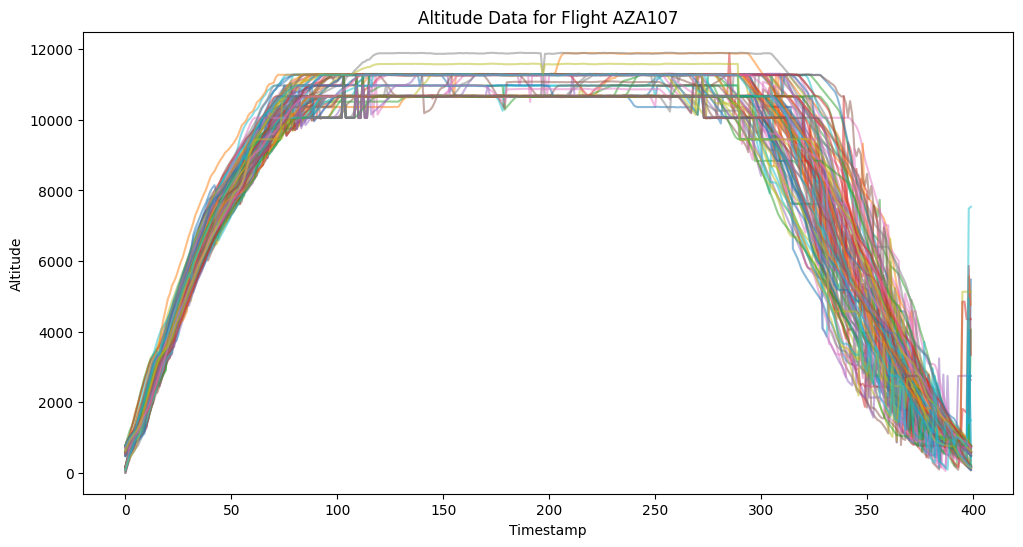

In [254]:
# Optionally, you can visualize a specific flight for verification

plt.figure(figsize=(12, 6))
for i in cleaned_flights[:100]:   
    #flight_to_plot = cleaned_flights[0]  # Example: plot the first flight
    df_plot = i.data
    plt.plot(np.arange(0, 400), df_plot['altitude'], alpha=0.5, label='Original Altitude')
    #plt.plot(df_plot['timestamp'], df_plot['altitude_cleaned'], 'g-', label='Cleaned Altitude (Outliers Removed)')
    #plt.plot(df_plot['timestamp'], df_plot['altitude_smoothed'], 'r-', label='Smoothed Altitude')
plt.xlabel('Timestamp')
plt.ylabel('Altitude')
plt.title(f'Altitude Data for Flight {flight_to_plot.callsign}')
#plt.legend
plt.show()

In [250]:
df_4[0].data['groundspeed']

0      157.0
1      159.0
2      155.0
3      160.0
4      178.0
       ...  
395    232.0
396    186.0
397    170.0
398    199.0
399    178.0
Name: groundspeed, Length: 400, dtype: float64

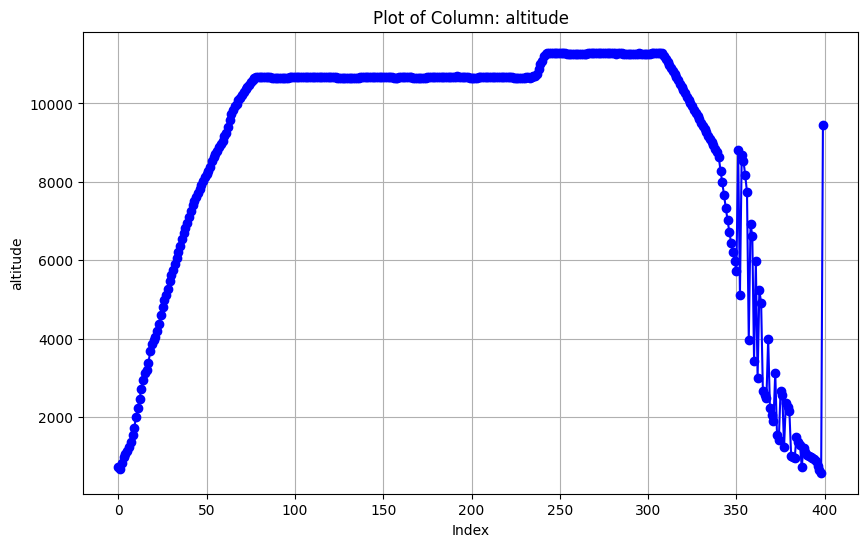

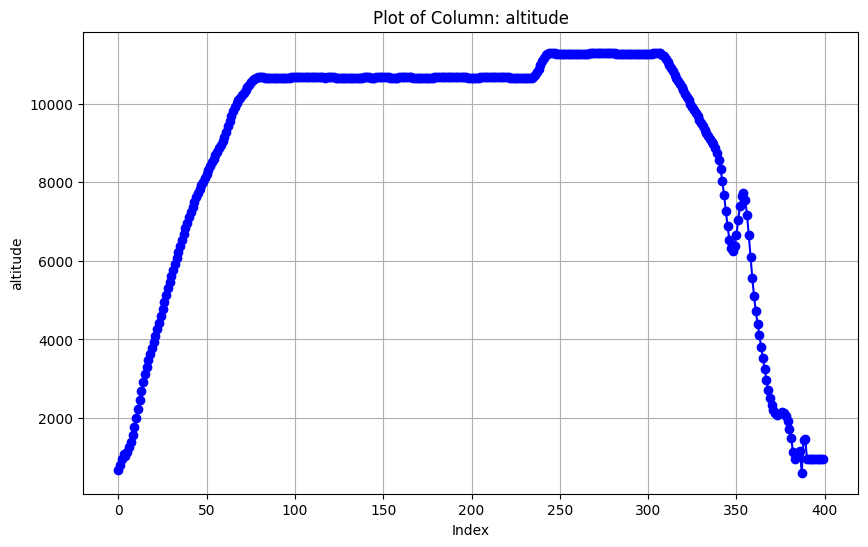

In [237]:
plot_column(df_4[2].data, "altitude")
plot_column(smoothed_altitude, "altitude")

#plot_column(smoothed_df, "altitude")
#plot_column(df_4[2].data, "altitude")
#plot_column(corrected_df, "altitude")

In [222]:
df_4.data.loc[399].describe()

,latitude,longitude,altitude,groundspeed,track,vertical_rate,hour,month,day_of_week,track_cos,track_sin,timedelta,cluster,track_unwrapped,cumdist,compute_gs,compute_track
count,7630.000000,7630.000000,7630.000000,7630.000000,7630.000000,7630.000000,7630.000000,7630.000000,7630.000000,7630.000000,7630.000000,7630.000000,7630.000000,7630.000000,7630.000000,7035.000000,7630.000000
mean,41.906860,12.231417,1929.317088,177.827916,193.518374,-937.545478,14.083626,6.840891,3.019135,-0.626003,0.170340,6254.442202,2.480341,192.763459,731.951426,187.949120,191.882570
std,0.104031,0.052989,3252.787432,34.821871,66.938190,327.317786,4.810093,3.497220,2.029640,0.704719,0.287318,405.787213,1.436129,106.710124,29.328859,135.609718,63.070744
min,41.428093,11.983018,22.860000,96.000000,0.647382,-4032.000000,0.000000,1.000000,0.000000,-1.000000,-0.999979,5424.000000,0.000000,-737.560272,679.268551,0.000000,0.396402
25%,41.868484,12.198450,518.160000,149.000000,162.456742,-1088.000000,9.733333,4.000000,1.000000,-0.955779,0.252980,5968.000000,1.000000,162.434985,710.281871,152.263125,162.461267
50%,41.930276,12.223631,769.620000,176.000000,162.783926,-896.000000,14.116667,7.000000,3.000000,-0.953994,0.295976,6205.000000,3.000000,162.778092,723.759646,186.519152,162.810890
75%,41.977172,12.251629,982.980000,201.000000,165.231766,-768.000000,17.966667,10.000000,5.000000,-0.950193,0.301426,6475.000000,4.000000,165.123947,747.795977,211.435853,180.000000
max,42.213776,12.557692,15880.080000,570.000000,352.583086,2240.000000,23.916667,12.000000,6.000000,0.999936,0.998828,10945.000000,4.000000,1602.747348,1057.253528,5178.794564,355.600336


In [149]:
import numpy as np
import pandas as pd
from scipy import stats
df_2 = Traffic.from_file('./resampled/combined_traffic_resampled_200.pkl')
df_2.data['altitude'] = df_2.data['altitude'] *  0.3048
def clean_trajectory_data(df, column, threshold=3):
    """
    Clean trajectory data by:
    1. Identifying and replacing outliers with NaN
    2. Interpolating missing values
    3. Falling back to mean if interpolation fails
    
    Parameters:
    df (pd.DataFrame): DataFrame containing trajectory data
    column (str): Column name to clean
    threshold (float): Number of standard deviations for outlier detection
    
    Returns:
    pd.Series: Cleaned data series
    """
    # Calculate z-scores to identify outliers
    z_scores = np.abs(stats.zscore(df[column]))
    
    # Create a copy of the data to modify
    cleaned_data = df[column].copy()
    
    # Replace outliers with NaN
    cleaned_data[z_scores > threshold] = np.nan
    
    # Try interpolation first
    interpolated_data = cleaned_data.interpolate(method='linear')
    
    # If interpolation fails (e.g., NaNs at start/end), use mean of non-NaN values
    if interpolated_data.isna().any():
        mean_value = interpolated_data.dropna().mean()
        interpolated_data.fillna(mean_value, inplace=True)
    
    return interpolated_data
    
for n in range(200):
    df_2.data.loc[n,'altitude'] = clean_trajectory_data(df_2.data.loc[n], 'altitude', 2)

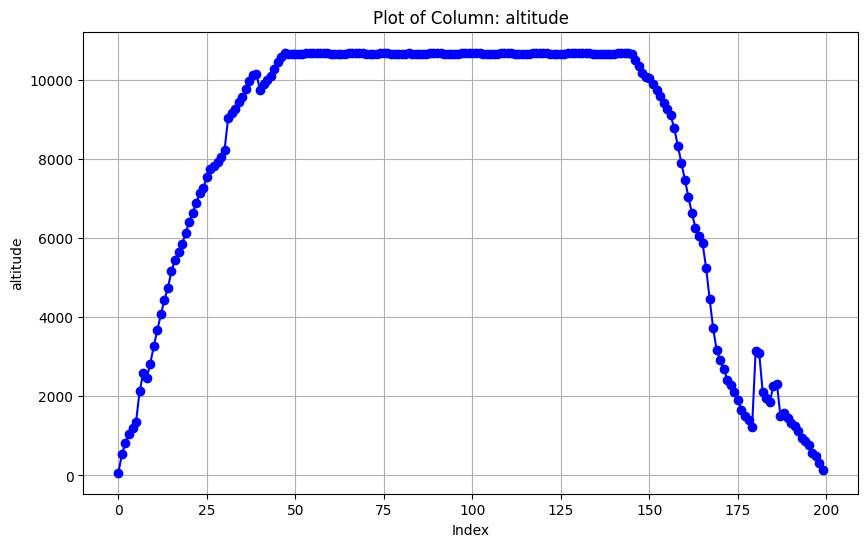

In [154]:
plot_column(df_2[5].data, "altitude")